### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [2]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [3]:
train_file_path = 'Resources/lab1_train.csv'
test_file_path = 'Resources/lab1_test.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

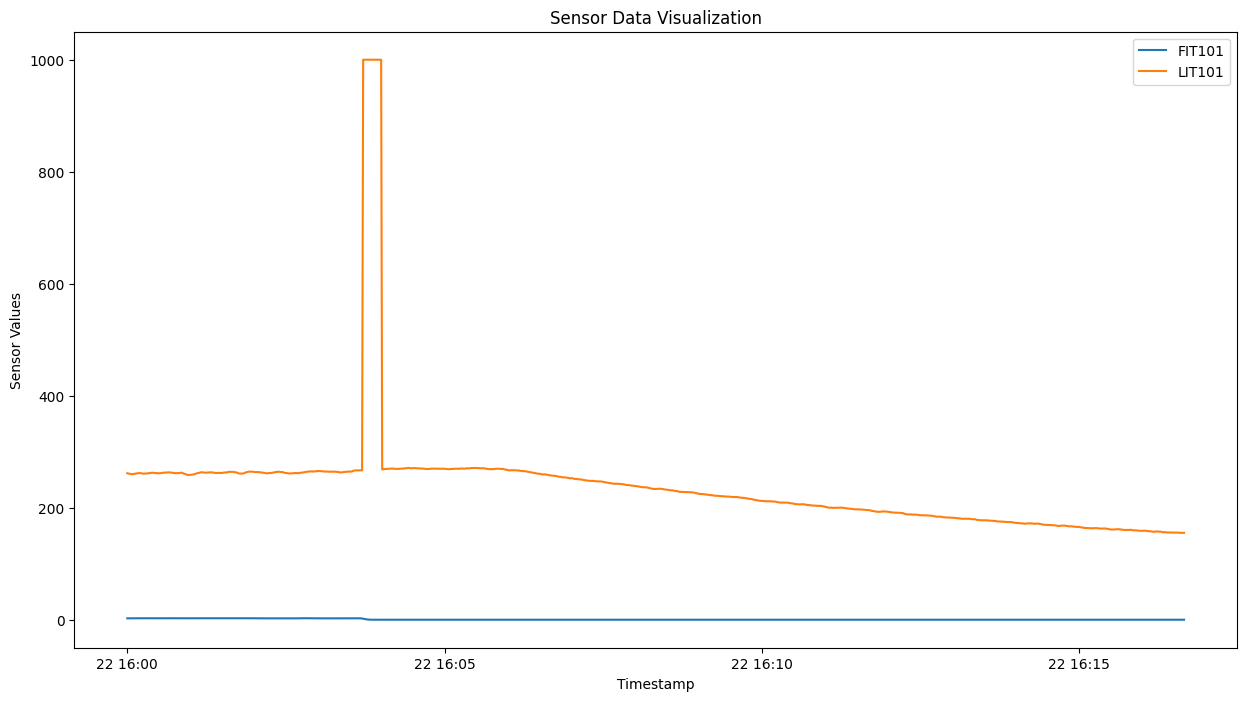

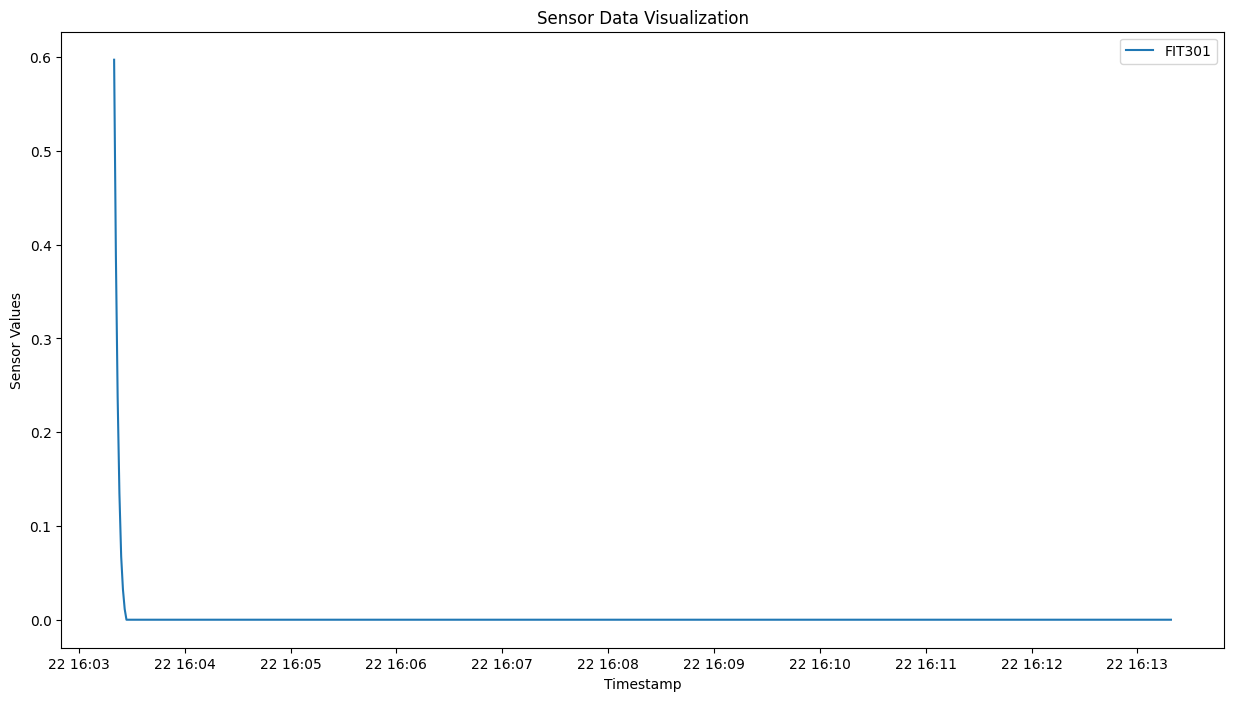

/Users/luca23bledea/Library/Mobile Documents/com~apple~CloudDocs/Downloads/University Year 2/Y2 Q1/Machine Learning/ML Python/Project freeCodeCadamy/.venv311/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


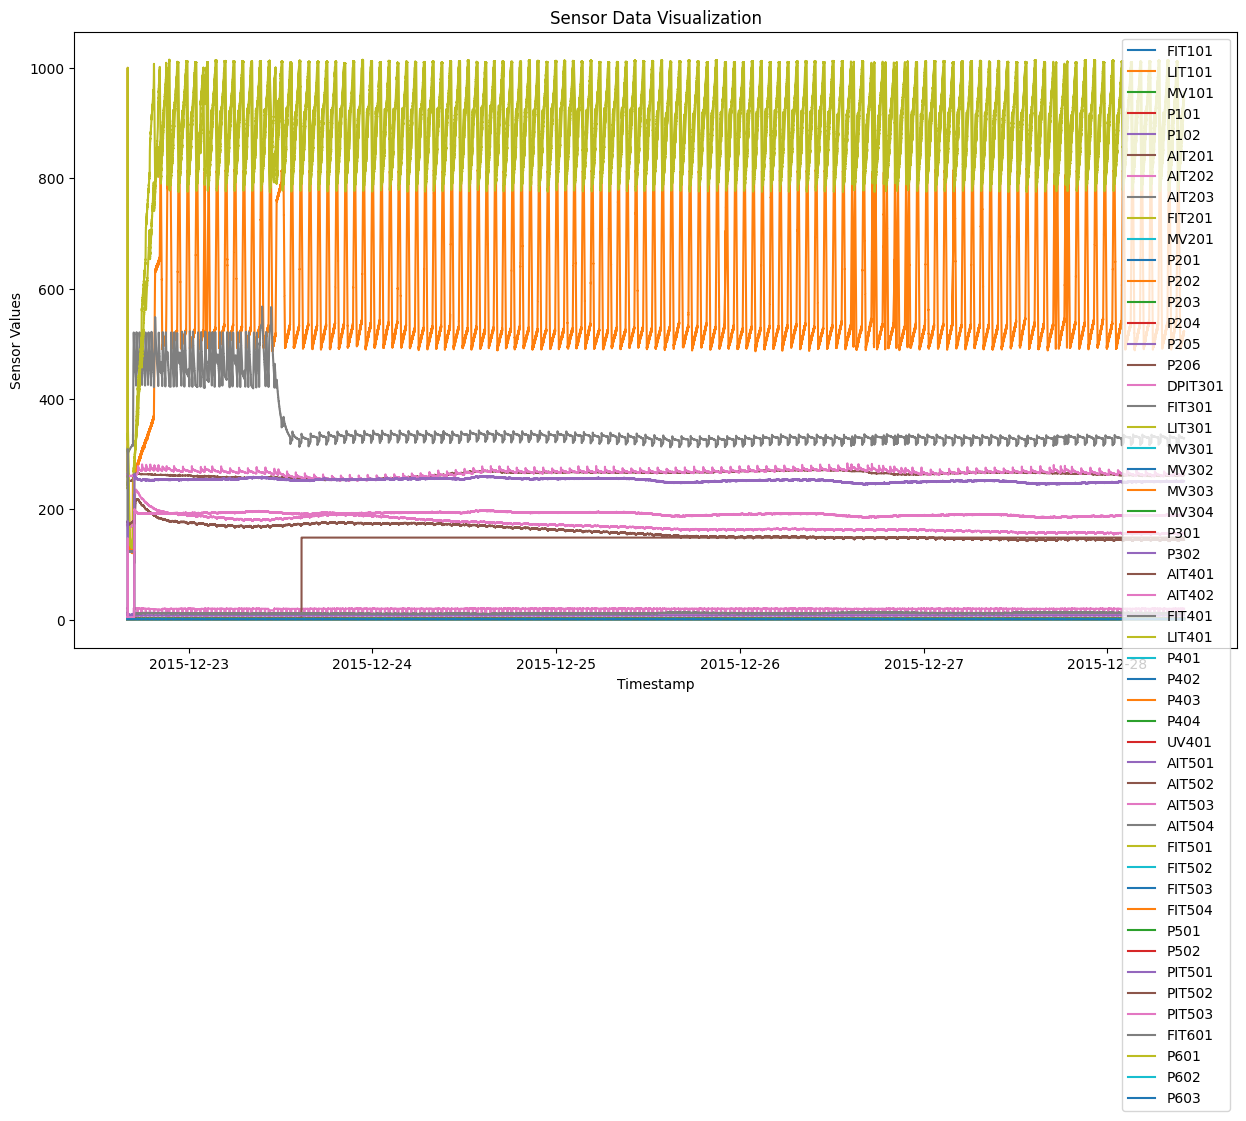

In [4]:
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101', 'LIT101'])
visualize_sensor_data(train_data, window=(200, 800), sensors=['FIT301'])
visualize_sensor_data(train_data)

# Familiarization

### 1. What types of signals are there?

#### a) Sensor AIT203

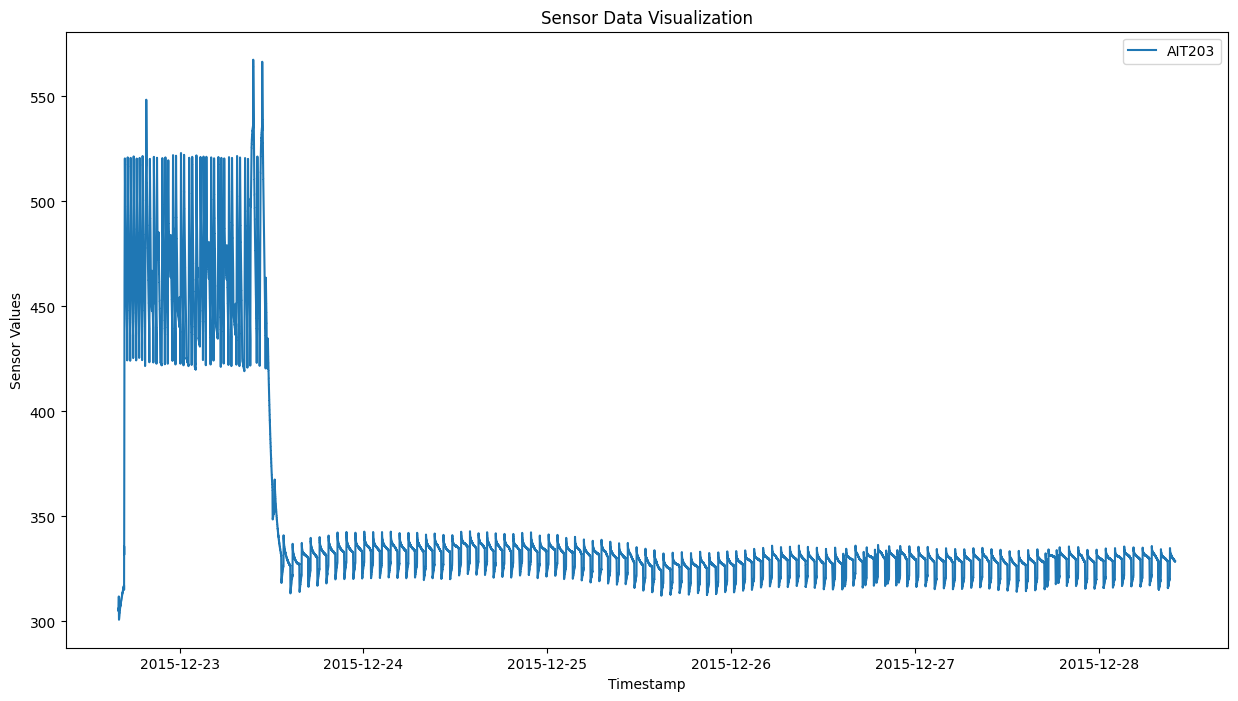

In [5]:
visualize_sensor_data(train_data, sensors=['AIT203'])

The **AIT203** sensor exhibits a clear two-regime behaviour with a transition point around December 23-24. The signal transitions from high-amplitude oscilations to more stable low-amplitude oscilations.

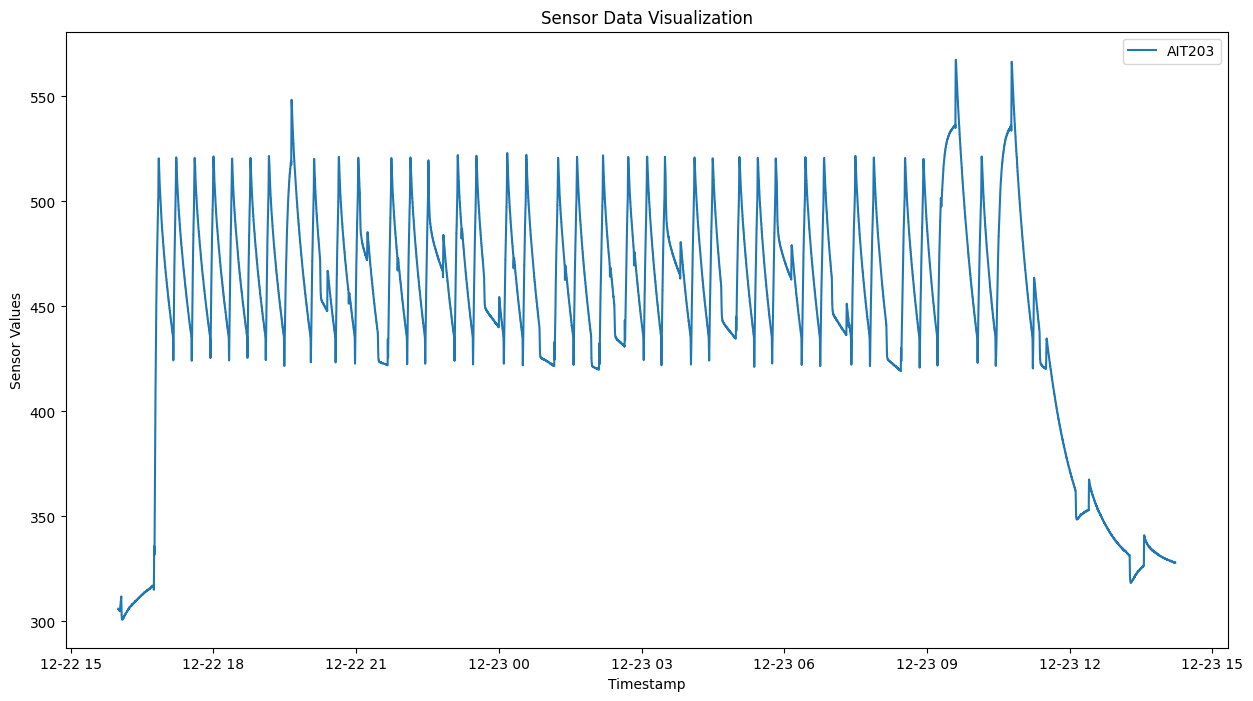

In [6]:
visualize_sensor_data(train_data, window=(0, 80000), sensors=['AIT203'])

Pattern 1 shows *cyclical behaviour* with oscilations between values 420 and 520 with occasional spikes reaching 550+. The amplitude range of aprox 130 units indicates high variance.

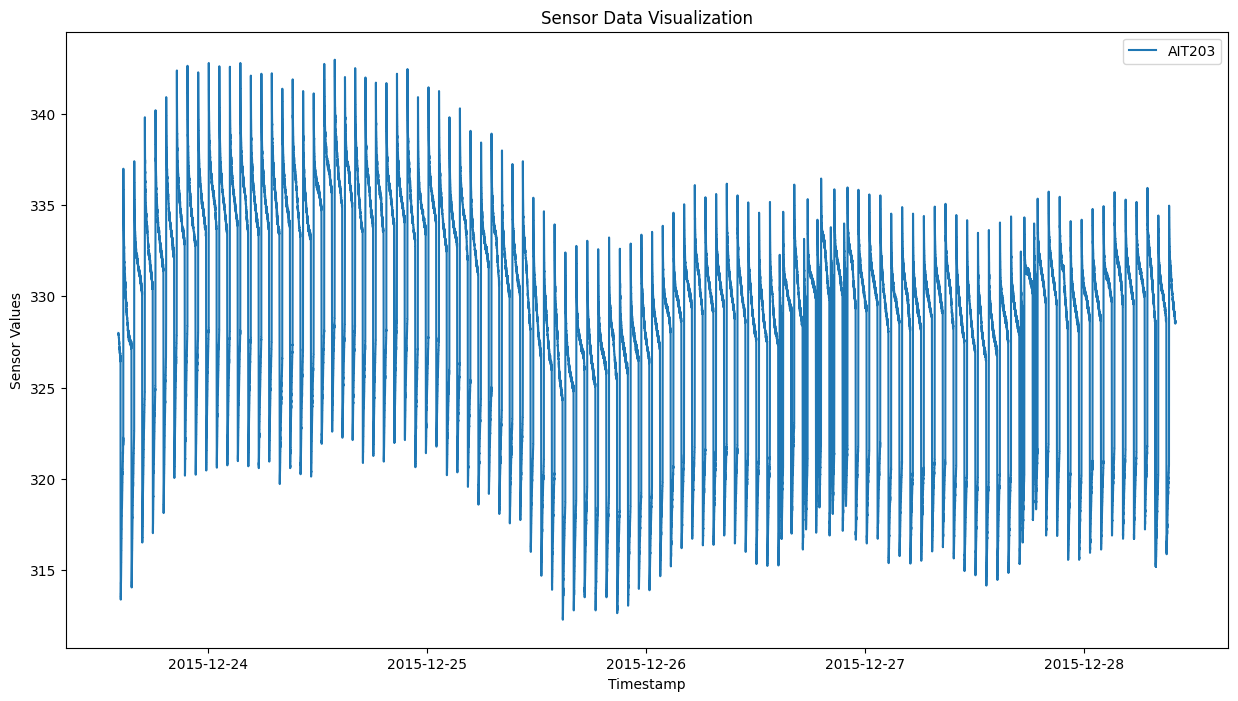

In [7]:
visualize_sensor_data(train_data, window=(80000, -1), sensors=['AIT203'])

The second pattern also shows *cyclical behavious* but with a lower baseline and more consistent oscialations variating from 310 to 350. 

#### b) Sensor P603

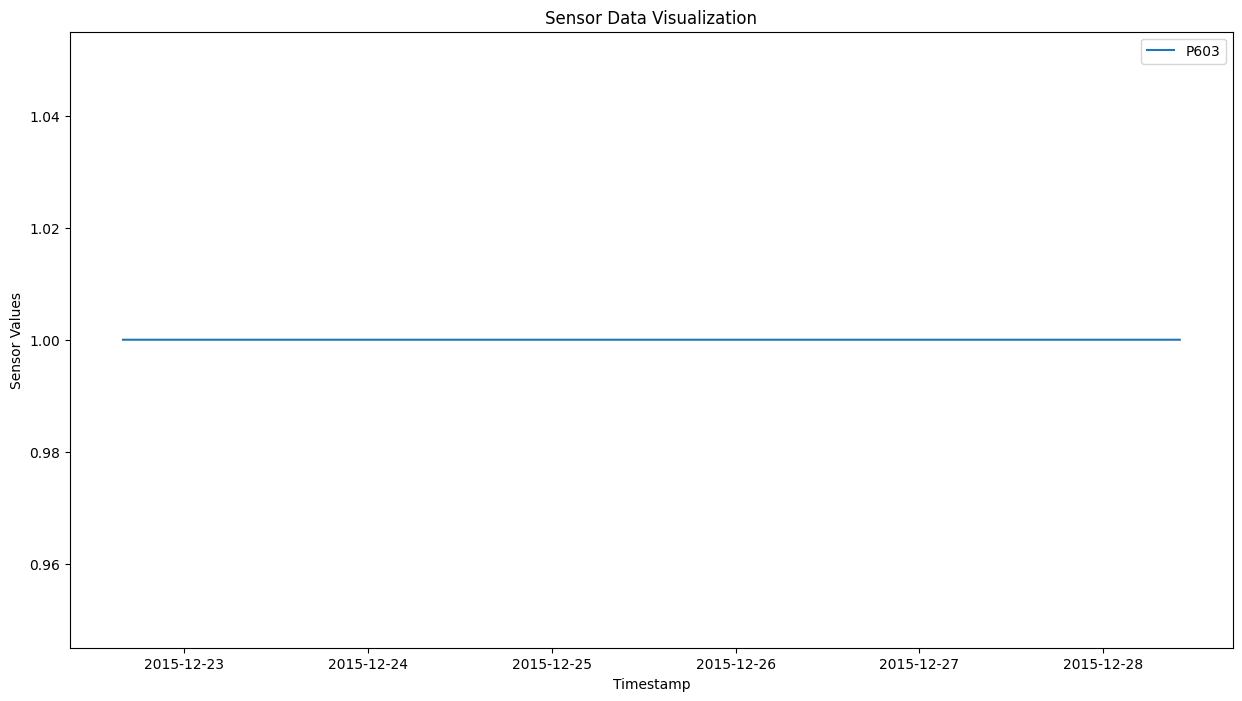

[1 1 1 ... 1 1 1]
496800


In [10]:
visualize_sensor_data(train_data, sensors=['P603'])

print(train_data["P603"].values)
print(len(train_data["P603"]))

The **P603** sensor displays a zero-variance signal, remaining flat at 1.00 throughout the entire time period. This shows that P603 is a *constant* sensor.

# DTW-based anomaly detection

For this assignment, given what we've analyzed at the last exercise, we've chosen the **AIT203** sensor. This is mainly because the AIT203 sensor displays clear and interesting temporal behaviour, including periodic oscilations, sudden spikes, and long term trends; these characteristics making window-based DTW very suitable in finding abnormalities.

### The DTW algorithm (fast)

We used a fast-DTW algorithm as we had to wait a long time in the first few runtimes, to compute the values. The choice of k was 10, so we could significantly speed up the implementation. 

**Why k=10?** Because it limits temporal warping to ±10 samples, which is appropriate for AIT203 since its oscillations are regular and smooth. Extreme time distortions (e.g., >20 sample shifts) are physically unrealistic for this sensor's slow cyclical behavior. This reduces DTW complexity from O(n²m²) to O(n×m×k).

In [30]:
def dynamic_time_warping(a, b, k):
    n = a.size
    m = b.size
    k = max(k, abs(n - m))
    
    # Initialize distance matrix with infinity
    dtw_distance = np.inf
    d = [[dtw_distance for _ in range(m + 1)] for _ in range(n + 1)]
    
    # Base case: distance from start point
    d[0][0] = 0
    
    # Compute DTW distance using dynamic programming
    for i in range(1, n + 1):
        j_start = max(1, i - k)
        j_end = min(m, i + k)

        for j in range(j_start, j_end+1):
            cost = abs(a[i - 1] - b[j - 1])
            d[i][j] = cost + min(d[i - 1][j], min(d[i][j - 1], d[i - 1][j - 1]))
    
    # Return square root of final distance
    return np.sqrt(d[n][m])

Using DTW distances on sliding windows mainly detects **collective anomalies**, so this is what we expect. However, it could also indirectly identify point and contextual anomalies whenever the windows disrupt the expected temporal shape of the signal.

### Sliding window creation

In [31]:
def create_sliding_windows(signal, window_size, stride):
    windows = []
    indices = []

    for i in range(0, len(signal) - window_size + 1, stride):
        windows.append(signal[i:i + window_size])
        indices.append(i)

    return windows, indices

### Compute Residual Distance

In [32]:
def compute_residuals(windows, repr_windows, r=10):
    residuals = []

    for w in windows:
        min_dist = float('inf')

        for rwin in repr_windows:
            dist = dynamic_time_warping(w, rwin, r)
            if dist < min_dist:
                min_dist = dist

        residuals.append(min_dist)

    return np.array(residuals)


### Put everything together

Again, we discovered that DTW is very expensive computationally as comparing each window to all other windows would be too slow. To reduce runtime, we build a subset of representative windows by taking every 10th window from the training data. <br>
This mainly preserves the structure, while reducing the computations by around 10x.

In [ ]:
def compute_dtw_residuals(train_data, test_data, sensor="AIT203", window_size=150, stride=1000, repr_step=10):

    # Extract AIT203 sensor
    ait203_train = train_data[sensor].values
    ait203_test = test_data[sensor].values

    # take every 3rd sample
    # ait203_train = ait203_train[::3]
    # ait203_test = ait203_test[::3]

    # Generate windows
    train_windows, train_idx = create_sliding_windows(ait203_train, window_size, stride)
    test_windows, test_idx = create_sliding_windows(ait203_test, window_size, stride)

    repr_train_windows = train_windows[::repr_step]     # every 10th window as representative

    # Compute DTW residuals
    train_res = compute_residuals(train_windows, repr_train_windows)
    test_res  = compute_residuals(test_windows, repr_train_windows )

    return train_res, test_res, train_idx, test_idx

### Plot the train and test residuals

In [44]:
def visualize_dtw_analysis(train_data, test_data, train_res, test_res, 
                          train_idx, test_idx, sensor='AIT203'):
    # Calculate threshold from training residuals
    train_mean = np.mean(train_res)
    train_std = np.std(train_res)
    threshold = train_mean + 2 * train_std

    # ========================================================================
    # Plot 1: TRAINING DATA with Residuals
    # ========================================================================

    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Left y-axis: Raw sensor signal (blue)
    color_signal = 'tab:blue'
    ax1.set_xlabel('Timestamp', fontsize=12)
    ax1.set_ylabel(f'{sensor} Sensor Value', color=color_signal, fontsize=12)
    ax1.plot(train_data['Timestamp'], train_data[sensor], 
             color=color_signal, alpha=0.5, linewidth=0.5, label=f'{sensor} Signal')
    ax1.tick_params(axis='y', labelcolor=color_signal)
    ax1.grid(True, alpha=0.3)

    # Right y-axis: DTW residuals (red)
    ax2 = ax1.twinx()
    color_residual = 'tab:red'
    ax2.set_ylabel('DTW Distance (Residual)', color=color_residual, fontsize=12)
    ax2.plot(train_data['Timestamp'].iloc[train_idx], train_res, 
             color=color_residual, linewidth=1.5, alpha=0.8, label='DTW Residuals')
    ax2.axhline(y=threshold, color='orange', linestyle='--', linewidth=2, 
                alpha=0.7, label=f'Threshold ({threshold:.1f})')
    ax2.tick_params(axis='y', labelcolor=color_residual)

    # Title and legends
    plt.title(f'Training Data: {sensor} Signal and DTW Residuals (Baseline)', 
              fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.show()

    # ========================================================================
    # Plot 2: TEST DATA with Residuals and Anomalies
    # ========================================================================

    # Detect anomalies
    anomaly_mask = test_res > threshold
    num_anomalies = np.sum(anomaly_mask)
    anomaly_rate = num_anomalies / len(test_res) * 100

    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Left y-axis: Raw sensor signal (blue)
    ax1.set_xlabel('Timestamp', fontsize=12)
    ax1.set_ylabel(f'{sensor} Sensor Value', color=color_signal, fontsize=12)
    ax1.plot(test_data['Timestamp'], test_data[sensor], 
             color=color_signal, alpha=0.5, linewidth=0.5, label=f'{sensor} Signal')
    ax1.tick_params(axis='y', labelcolor=color_signal)
    ax1.grid(True, alpha=0.3)

    # Right y-axis: DTW residuals (red)
    ax2 = ax1.twinx()
    ax2.set_ylabel('DTW Distance (Residual)', color=color_residual, fontsize=12)
    ax2.plot(test_data['Timestamp'].iloc[test_idx], test_res, 
             color=color_residual, linewidth=1.5, alpha=0.8, label='DTW Residuals')
    ax2.axhline(y=threshold, color='orange', linestyle='--', linewidth=2.5, 
                alpha=0.8, label=f'Threshold ({threshold:.1f})')

    # Highlight anomalies with red X markers
    if num_anomalies > 0:
        anomaly_timestamps = test_data['Timestamp'].iloc[test_idx].values[anomaly_mask]
        anomaly_distances = test_res[anomaly_mask]
        ax2.scatter(anomaly_timestamps, anomaly_distances, 
                   color='darkred', s=60, marker='x', linewidths=2,
                   zorder=5, label=f'Anomalies ({num_anomalies})', alpha=0.9)

    ax2.tick_params(axis='y', labelcolor=color_residual)

    # Title and legends
    plt.title(f'Test Data: {sensor} Signal, DTW Residuals, and Detected Anomalies', 
              fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.show()

- ### Window size = 150, stride = 1000

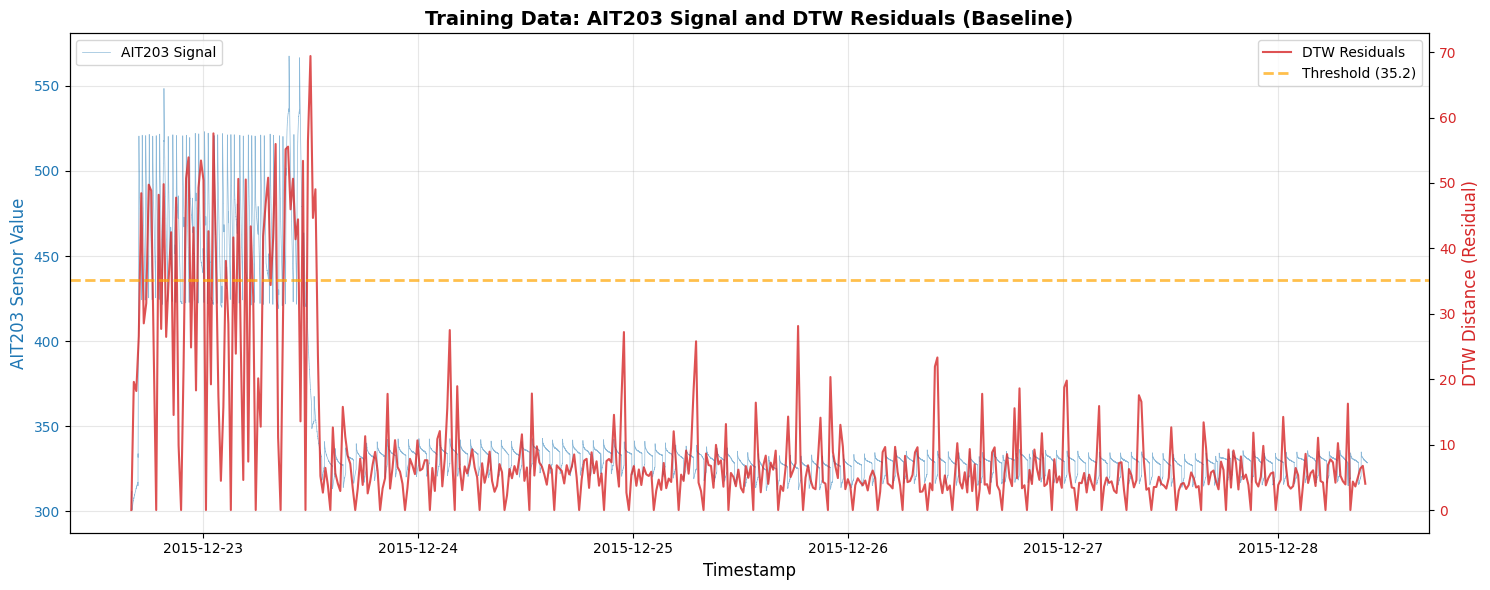

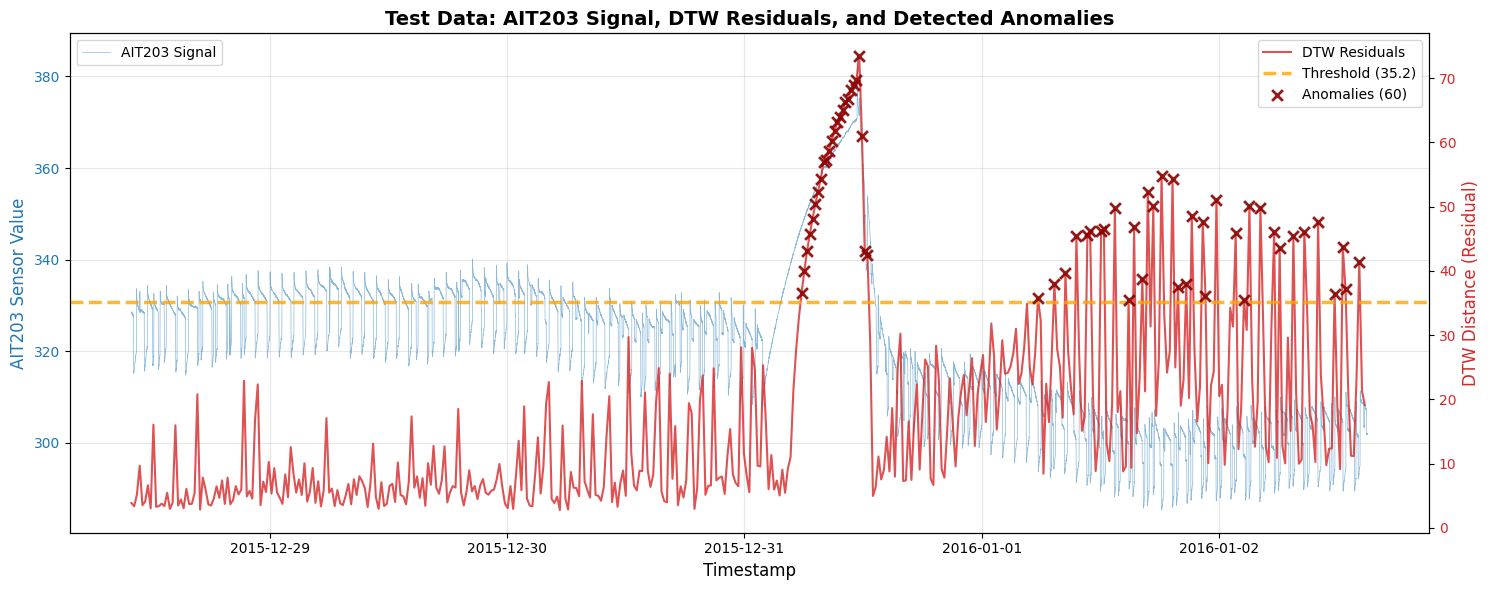

In [48]:
train_res, test_res, train_idx, test_idx = compute_dtw_residuals(train_data, test_data, window_size=150, stride=1000)
visualize_dtw_analysis(train_data, test_data, train_res, test_res, train_idx, test_idx, "AIT203")

DTW residuals over 150-point windows show stable behavior in training data, with moderate noise around a baseline.<br>
In test data, a large spike around Dec 31–Jan 1 is clearly detected as a collective anomaly, representing a multi-hour deviation. Later drifts on Jan 1–2 are also flagged, indicating sustained abnormal behavior.<br>
Detected anomaly types:
- collective anomalies as talked about above
- contextual anomalies appear when similar ranges show different trend shapes
- point anomalies are not detected because of the long window
<br>
Overall, this configuration is effective for detecting shape changes, provides good sensitivity, a moderate number of detections, and manageable false alarms.

- ### Window size = 300, stride = 1000

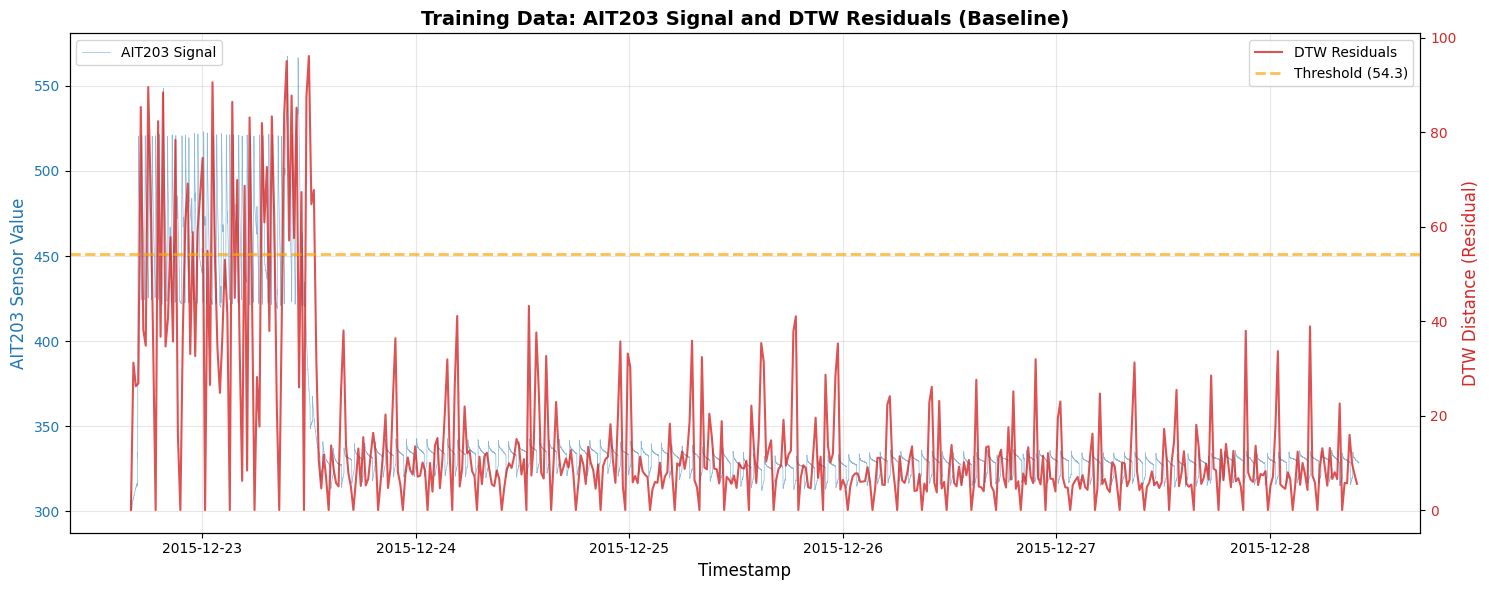

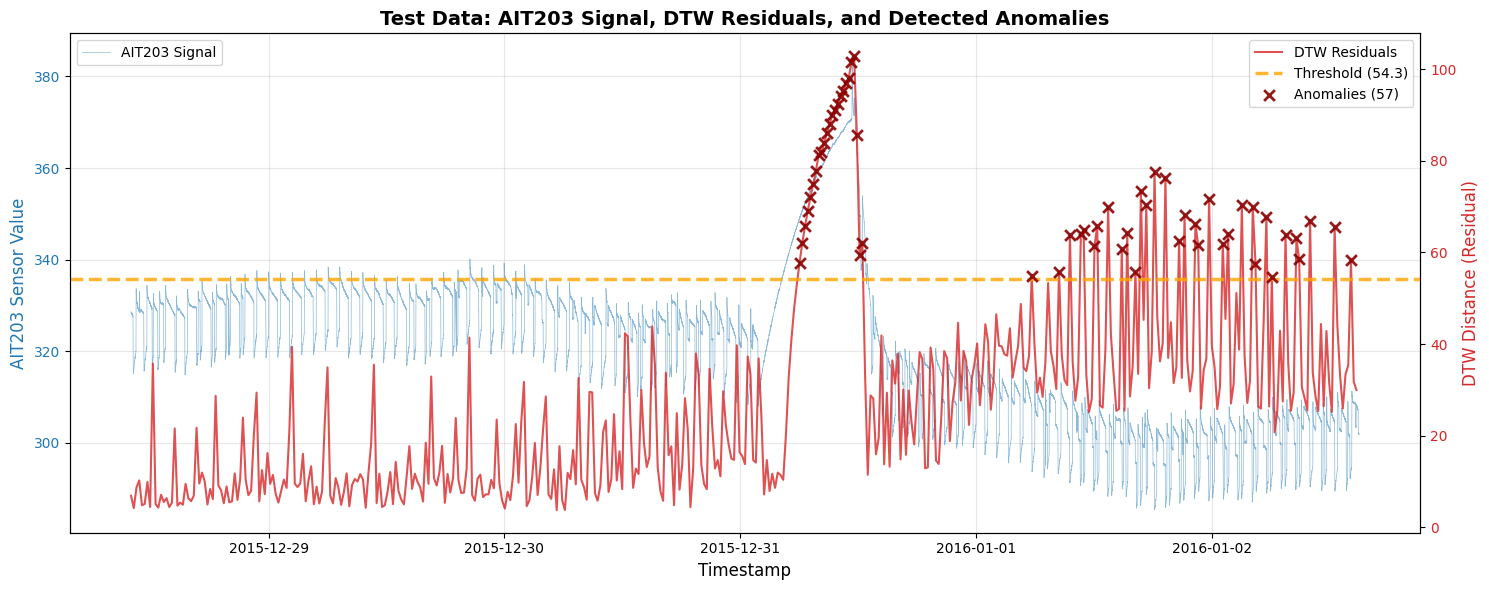

In [49]:
train_res, test_res, train_idx, test_idx = compute_dtw_residuals(train_data, test_data, window_size=300, stride=1000)
visualize_dtw_analysis(train_data, test_data, train_res, test_res, train_idx, test_idx, "AIT203")

DTW residuals with a window size of 300 and stride of 1000 show slightly higher training residuals due to larger windows.<br>
In test data, the large deviation around Dec 31 is still detected, but fewer anomalies appear around Jan 1–2.
<br>Detected anomaly types:
- collective are captured best as long windows emphasize multi-window deviations and regime changes
- (some) contextual anomalies are detected, but fewer than with shorter windows because longer windows enforce consistency
- point anomalies are not detected since single spikes are smoothed out
<br>
Overall, this configuration is the most stable, with low sensitivity. It misses subtle or short events but is ideal for reducing false alarms and focusing on severe drift.

- ### Window size = 150, stride = 3000


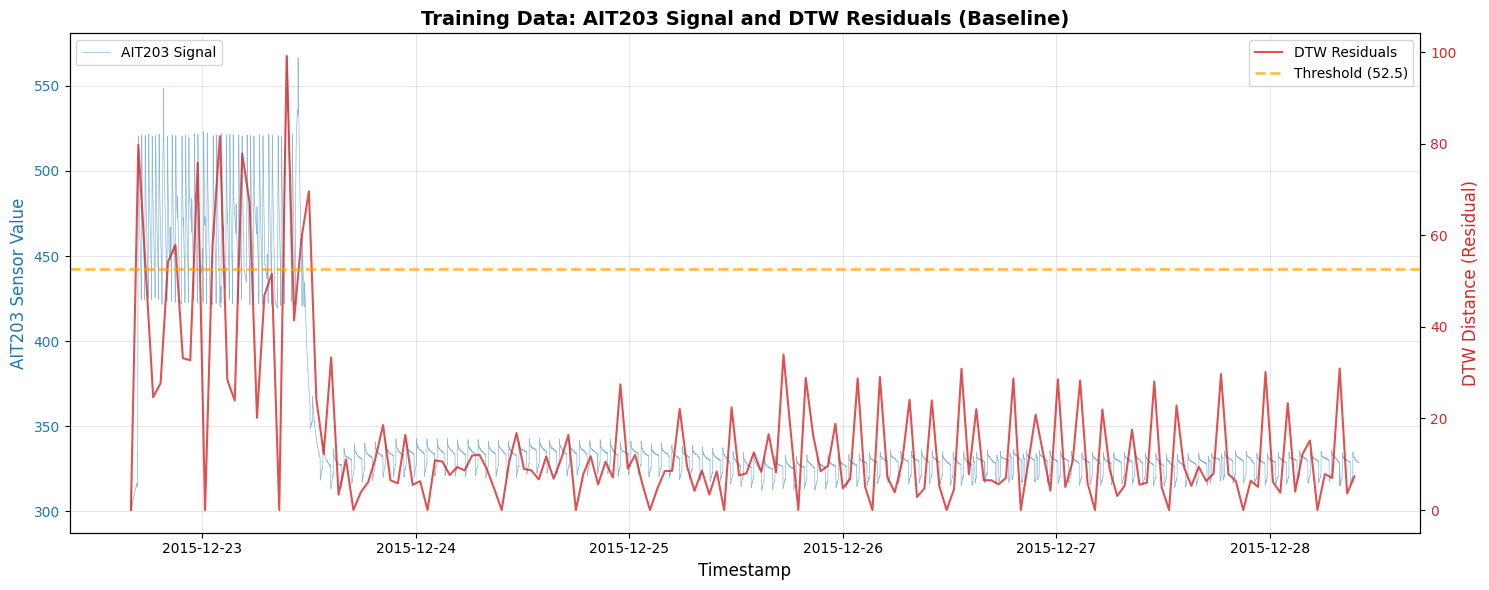

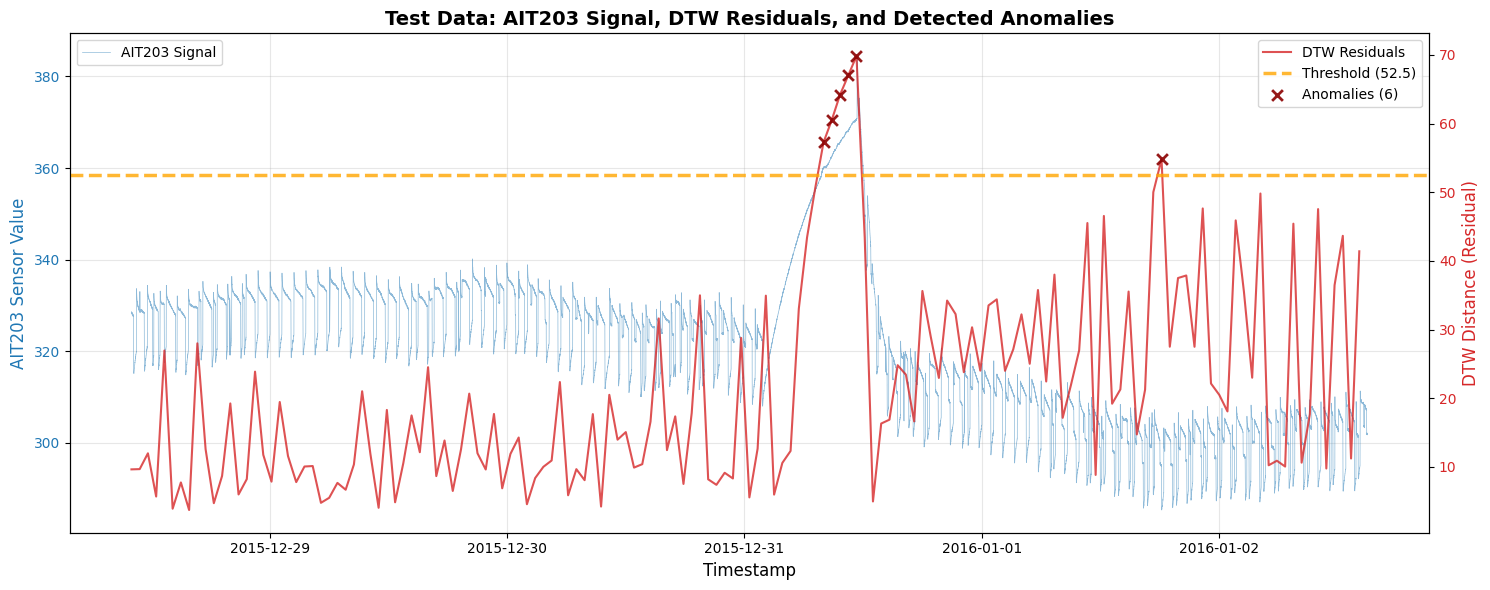

In [52]:
train_res, test_res, train_idx, test_idx = compute_dtw_residuals(train_data, test_data, window_size=150, stride=3000)
visualize_dtw_analysis(train_data, test_data, train_res, test_res, train_idx, test_idx, "AIT203")

DTW residuals with stride 3000 produce training residuals of similar shape but with fewer windows, making the representation coarse.
<br>In test data, the large anomaly around Dec 31 is detected, but most subsequent anomalies are missed because the stride skips large portions of the signal. Only about six anomalies are identified.
<br>Detected anomaly types:
- large collective anomalies are captured, as only multi-hour deviations are visible
- contextual anomalies are not detected since the stride is too large and windows barely overlap
- point anomalies are completely ignored
<br>
Overall, this setup is fast but sacrifices resolution. The large gaps between windows prevent detection of fine-grained abnormal behavior. It is suitable only when runtime efficiency is more important than sensitivity.

#### Conclusion
After experimenting with three configurations, we rank them as follows: **(1) w=150, s=1000** -> best overall, **(2) w=300, s=1000** —> conservative but precise, **(3) w=150, s=3000** —> fast but too sparse. The first configuration provides the best balance between anomaly detectability (collective + contextual), false alarms, and runtime: 150-sample windows capture meaningful temporal shapes while stride 1000 limits DTW computations to a feasible number. The second configuration reduces false positives but oversmoothes short anomalies, and the third trades detection for speed. Therefore w=150, s=1000 is our recommended setting.